In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from typing import List, Callable

Neural differential solver functionality:

In [14]:
class DNN(nn.Module):
    def __init__(self, input_shape: int, hidden_shapes: List[int], output_shape: int, activations: List[Callable] = None):
        super(DNN, self).__init__()
        depth = len(hidden_shapes)
        if activations is None:
            activations = [nn.Sigmoid() for _ in range(depth)]  # sigmoid as default
        else:
            assert len(activations) == depth
        layers = []
        layers.append(nn.Linear(input_shape, hidden_shapes[0]))
        layers.append(activations[0])
        for layer_i in range(1, depth):
            layers.append(nn.Linear(hidden_shapes[layer_i-1], hidden_shapes[layer_i]))
            layers.append(activations[layer_i])
        layers.append(nn.Linear(hidden_shapes[-1], output_shape))
        self.model = nn.Sequential(*layers)  # unpack list by `*list`

    def forward(self, x: torch.Tensor):
        return self.model(x)


def calcGradients(function, x, order):
    y = function(x)
    if order == 0:
        return y
    f_primes = torch.ones_like(x)
    for order_i in range(order):
        # Possibly you could create graph only for order_i+1 < order
        f_primes = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=f_primes, create_graph=True, retain_graph=True)[0]
        y = f_primes
    return f_primes


class LossFunction(nn.Module):
    def __init__(self, differential_expressions: List[Callable], bc_grad_orders: List[int], 
                 bc_functions: list[Callable], bc_boundaries: List[float], ):
        super(LossFunction, self).__init__()
        self.differential_expressions = differential_expressions
        self.problem_order = len(bc_boundaries)
        self.bc_grad_orders = bc_grad_orders
        self.bc_functions = bc_functions
        bc_boundaries_temp = [float(b) for b in bc_boundaries]
        self.bc_boundaries = torch.tensor(bc_boundaries_temp, requires_grad=True)
        assert self.problem_order == len(self.bc_grad_orders) and self.problem_order == len(self.bc_functions)

    def _calcBoundaryCondition(self, model: nn.Module, bc_boundaries: torch.Tensor):
        bc_terms = []
        for bc_i, bc_boundary in enumerate(bc_boundaries):
            term1 = calcGradients(model, bc_boundary, self.bc_grad_orders[bc_i])  # grad_x^p_i model(x_{b_i})
            term2 = self.bc_functions[bc_i](bc_boundary)  # K_i(x_{p_i})
            if not isinstance(term2, torch.Tensor): 
                term2 = torch.tensor([term2], requires_grad=True)  # Make sure term2 is tensor which grad is tracked
            # QUESTION If the function `bc_functions[bc_i]` returns a constant, does it matter if the (newly created!) tensor
            # tracks the gradient or not?
            bc_term_i = (term1 - term2)**2
            bc_terms.append(bc_term_i)
        return torch.sum(torch.stack(bc_terms))

    def __call__(self, model: nn.Module, x_data: torch.Tensor, include_all_bc: bool = False):
        x_max = x_data.shape[0]
        F_term = self.differential_expressions(model, x_data).square().sum() / x_max
        if include_all_bc:
            # That wont work. It should be tensor with shape like x_data!!!
            bc_boundaries_mask = [True for _ in range(self.problem_order)]
        else:
            bc_boundaries_mask = torch.isin(x_data, self.bc_boundaries)
        if bc_boundaries_mask.any():
            bc_boundaries_present = x_data[bc_boundaries_mask]
            bc_boundaries_present = bc_boundaries_present.unsqueeze(-1)
            bc_term = self._calcBoundaryCondition(model, bc_boundaries_present)
        else:
            bc_term = 0.0
        return F_term + bc_term


def training(model, loss_fn, dataloader, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    model.train()  # Make sure to be in train mode
    for epoch_i in range(num_epochs):
        running_loss = 0.0
        for batch_i, batch_x in enumerate(dataloader):
            # Input data in appropriate shape
            batch_x = batch_x.unsqueeze(-1)
            # NB no need to specifically calculate forward push
            # Backpropagation
            optimizer.zero_grad()
            loss = loss_fn(model, batch_x)
            loss.backward()
            optimizer.step()
            # Keep track of loss
            running_loss += loss.item()
        
        loss_history.append(running_loss)
        # Print progress
        print("Epoch {}/{} Loss: {:.4f}". format(epoch_i+1, num_epochs, running_loss))

    return loss_history

        

## Example 1
Solve $f'(x) - x - 1 = 0$ with boundary condition $f(0) = 0$ on $x \in [0,\infty]$. Analytic solution is $f(x) = x^2 / 2 + x + c$ where now $c = 0$.

Epoch 1/100 Loss: 4.3283
Epoch 2/100 Loss: 2.9736
Epoch 3/100 Loss: 1.6464
Epoch 4/100 Loss: 0.6605
Epoch 5/100 Loss: 0.3995
Epoch 6/100 Loss: 1.2681
Epoch 7/100 Loss: 1.0204
Epoch 8/100 Loss: 0.7991
Epoch 9/100 Loss: 0.4146
Epoch 10/100 Loss: 0.3444
Epoch 11/100 Loss: 0.3988
Epoch 12/100 Loss: 0.4861
Epoch 13/100 Loss: 0.5055
Epoch 14/100 Loss: 0.4061
Epoch 15/100 Loss: 0.3084
Epoch 16/100 Loss: 0.2559
Epoch 17/100 Loss: 0.2365
Epoch 18/100 Loss: 0.2802
Epoch 19/100 Loss: 0.2578
Epoch 20/100 Loss: 0.2401
Epoch 21/100 Loss: 0.1768
Epoch 22/100 Loss: 0.2231
Epoch 23/100 Loss: 0.1725
Epoch 24/100 Loss: 0.1419
Epoch 25/100 Loss: 0.1982
Epoch 26/100 Loss: 0.1115
Epoch 27/100 Loss: 0.0831
Epoch 28/100 Loss: 0.1188
Epoch 29/100 Loss: 0.0877
Epoch 30/100 Loss: 0.0874
Epoch 31/100 Loss: 0.0561
Epoch 32/100 Loss: 0.0500
Epoch 33/100 Loss: 0.0637
Epoch 34/100 Loss: 0.0381
Epoch 35/100 Loss: 0.0474
Epoch 36/100 Loss: 0.0336
Epoch 37/100 Loss: 0.0609
Epoch 38/100 Loss: 0.0399
Epoch 39/100 Loss: 0.

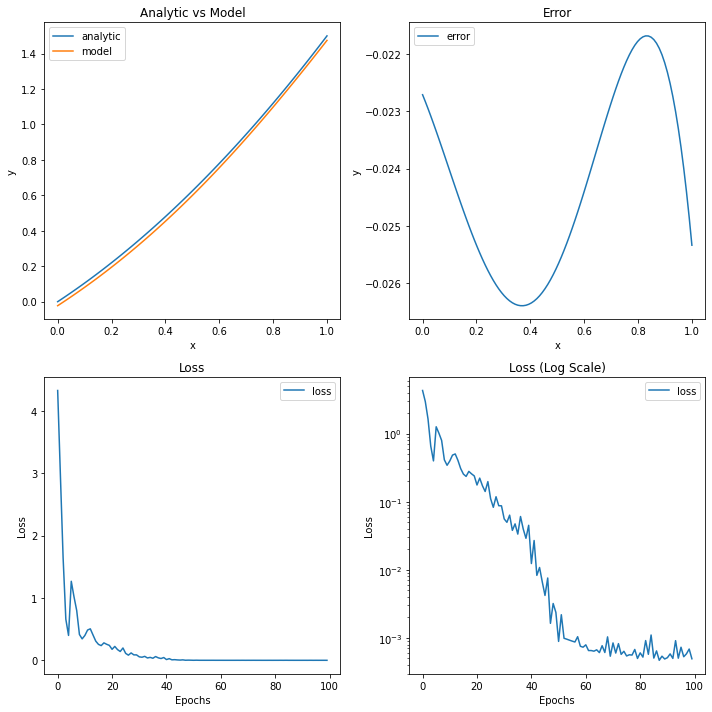

In [15]:
# --- Problem definitions ---
def equation(f, x):
    f_prime = calcGradients(f, x, 1)
    return f_prime - x - 1

def bc_function_1(x):
    return 0.0

bc_functions = [bc_function_1]
bc_ps = [0]
bc_xs = [0.0]

x_min = 0.0
x_max = 1.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
batch_size = 50
batch_shuffle = True

x = np.arange(x_min, x_max, discretization)
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [100, 100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 100
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    return x**2 * 0.5 + x

model.eval()
x_eval = np.linspace(0,1,100)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Plot 2: Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Plot 3: Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Plot 4: Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

## Example 2
Solve f''(x) - f'(x) + f(x) - 1 = 0 which has analytic solution $f(x) = c_2 e^{x/2} \sin(\sqrt{3} x / 2) + c_1 e^{x/2} \cos(\sqrt{3} x / 2) + 1$. For domain $x \in [0, 10]$ with boundary conditions $f(0) = 0$ and $f(10) = 0$ you have $c_1 = -1$, $c_2 = \frac{\csc \left(5 \sqrt{3}\right)-e^5 \cot \left(5 \sqrt{3}\right)}{e^5}$.

Epoch 1/1000 Loss: 4.6451
Epoch 2/1000 Loss: 0.8557
Epoch 3/1000 Loss: 1.9076
Epoch 4/1000 Loss: 0.7925
Epoch 5/1000 Loss: 1.2699
Epoch 6/1000 Loss: 0.8833
Epoch 7/1000 Loss: 1.0347
Epoch 8/1000 Loss: 0.8936
Epoch 9/1000 Loss: 0.9251
Epoch 10/1000 Loss: 0.8350
Epoch 11/1000 Loss: 0.8393
Epoch 12/1000 Loss: 0.7645
Epoch 13/1000 Loss: 0.7738
Epoch 14/1000 Loss: 0.7923
Epoch 15/1000 Loss: 0.8244
Epoch 16/1000 Loss: 0.7629
Epoch 17/1000 Loss: 0.8980
Epoch 18/1000 Loss: 0.8892
Epoch 19/1000 Loss: 0.8034
Epoch 20/1000 Loss: 0.8834
Epoch 21/1000 Loss: 0.8259
Epoch 22/1000 Loss: 0.9038
Epoch 23/1000 Loss: 1.0924
Epoch 24/1000 Loss: 0.8082
Epoch 25/1000 Loss: 0.8204
Epoch 26/1000 Loss: 0.7851
Epoch 27/1000 Loss: 0.7689
Epoch 28/1000 Loss: 0.9288
Epoch 29/1000 Loss: 0.9319
Epoch 30/1000 Loss: 0.8210
Epoch 31/1000 Loss: 0.8148
Epoch 32/1000 Loss: 0.8411
Epoch 33/1000 Loss: 0.9583
Epoch 34/1000 Loss: 1.1113
Epoch 35/1000 Loss: 0.8106
Epoch 36/1000 Loss: 0.7984
Epoch 37/1000 Loss: 0.7392
Epoch 38/1

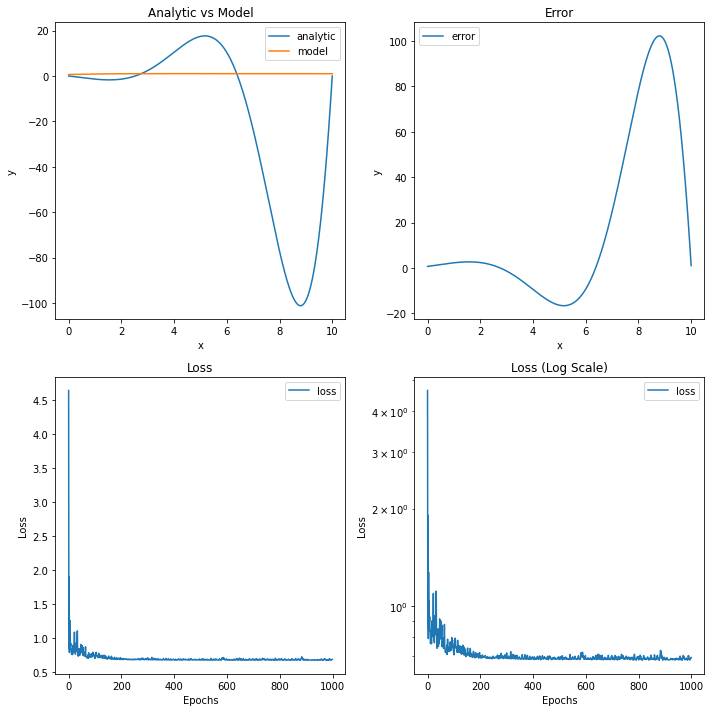

In [23]:
# --- Problem definitions ---
def equation(f, x):
    grad2_fx = calcGradients(f, x, 2)
    grad1_fx = calcGradients(f, x, 1)
    fx = f(x)
    return grad2_fx - grad1_fx + fx - 1

def bc_function_1(x):
    return 0.0

def bc_function_2(x):
    return 0.0

bc_functions = [bc_function_1, bc_function_2]
bc_ps = [0, 0]
bc_xs = [0.0, 10.0]

x_min = 0.0
x_max = 10.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
batch_size = 100
batch_shuffle = False

x = np.arange(x_min, x_max, discretization)
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [500, 200, 100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 1000
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    c1 = -1
    c2 = -1/(np.exp(5)*np.sin(5*np.sqrt(3))) + np.cos(5*np.sqrt(3))/np.sin(5*np.sqrt(3))
    cos_term = c1*np.cos(np.sqrt(3)*x/2)
    sin_term = c2*np.sin(np.sqrt(3)*x/2)
    return 1 + np.exp(x/2)*(cos_term + sin_term)

model.eval()
x_eval = np.linspace(x_min,x_max,1000)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Plot 2: Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Plot 3: Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Plot 4: Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

In [10]:
torch.tensor([1.2])+0.4

tensor([1.6000])